In [ ]:
#@title Viscoporoelastic Model Inversion

# Setup

In [78]:
#@markdown Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker

import warnings
warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)


3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [79]:
#@markdown Mount google drive and import my code

try:
    from google.colab import drive
    drive.mount('/content/drive')
    new_path = "/content/drive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src"
    if new_path not in sys.path:
      sys.path.insert(0,new_path)
except ModuleNotFoundError:
    import traceback
    traceback.print_exc()

#from src.euler_inversion import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
from euler_inversion import euler_inversion
import plotting
import viscoporoelastic_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Simple Laplace Model Inversion

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

anal_offset = 1
# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10*anal_offset
times=np.arange(0.1,100,0.1)/100.0*10*anal_offset

a=-3.03
#func = lambda s: 1/(s-a)
func = lambda s: 1/(s-a)
inv_func_anal = lambda t: np.exp(a*t)

input_times = times
plot_times  = times
func_name = {"t":"f(t)", "s":"F(s)"}
x_names   = {"t":"t", "s":"s"}
s_vals = np.arange(0.05, 5.05, 0.05)
input_times_anal = input_times /anal_offset
plot_times_anal = plot_times /anal_offset


fig=plotting.plot_laplace_analysis(func=func, func_name=func_name, time_const=1, x_names=x_names, input_s=s_vals, input_times=input_times, plot_times=plot_times, input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_func_anal=inv_func_anal )


# Key Points from Prior Paper
Yuan, D., Somers, S.M., Grayson, W.L. et al. A Poroelastic Model of a Fibrous-Porous Tissue Engineering Scaffold. Sci Rep 8, 5043 (2018). https://doi.org/10.1038/s41598-018-23214-8

## Figure 1
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-23214-8/MediaObjects/41598_2018_23214_Fig1_HTML.jpg?as=webp">

## Table 1
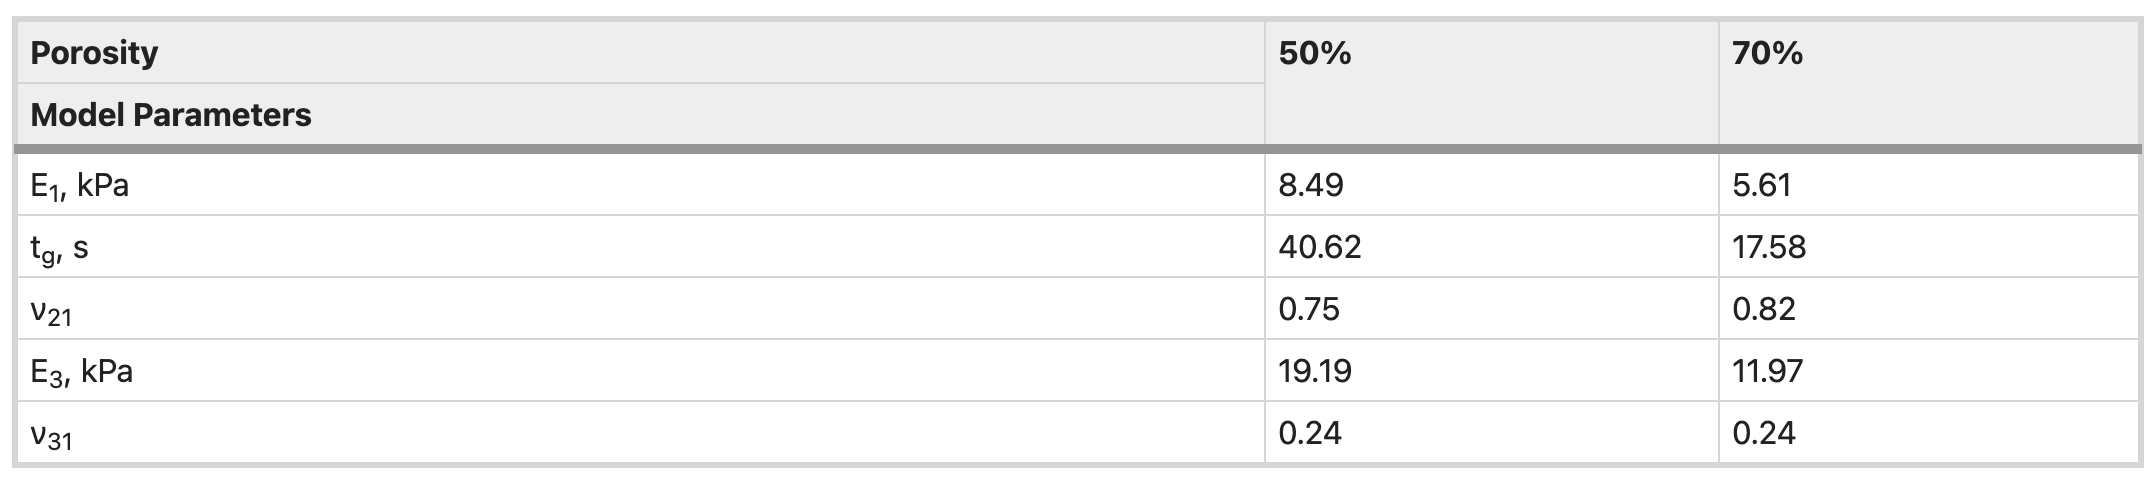

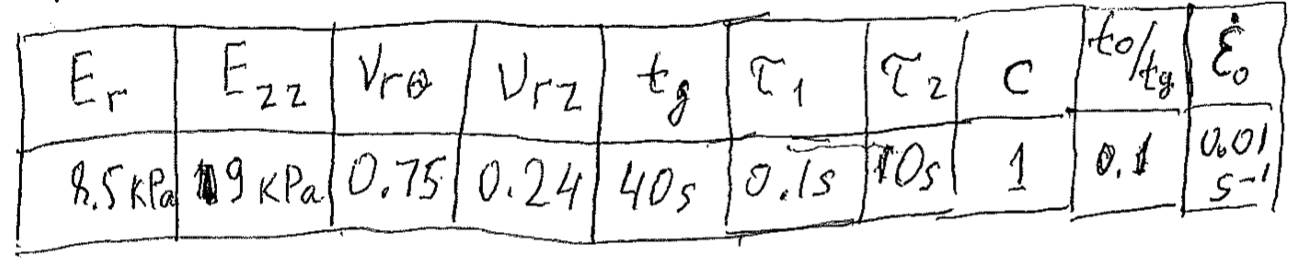

# Viscoporoelastic model inversion

Automatic pdb calling has been turned ON
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
It took 0.7702 sec to numerically invert laplace the func for 1001 input times.


,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err
ViscoporoelasticModel1,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.75,8.49


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

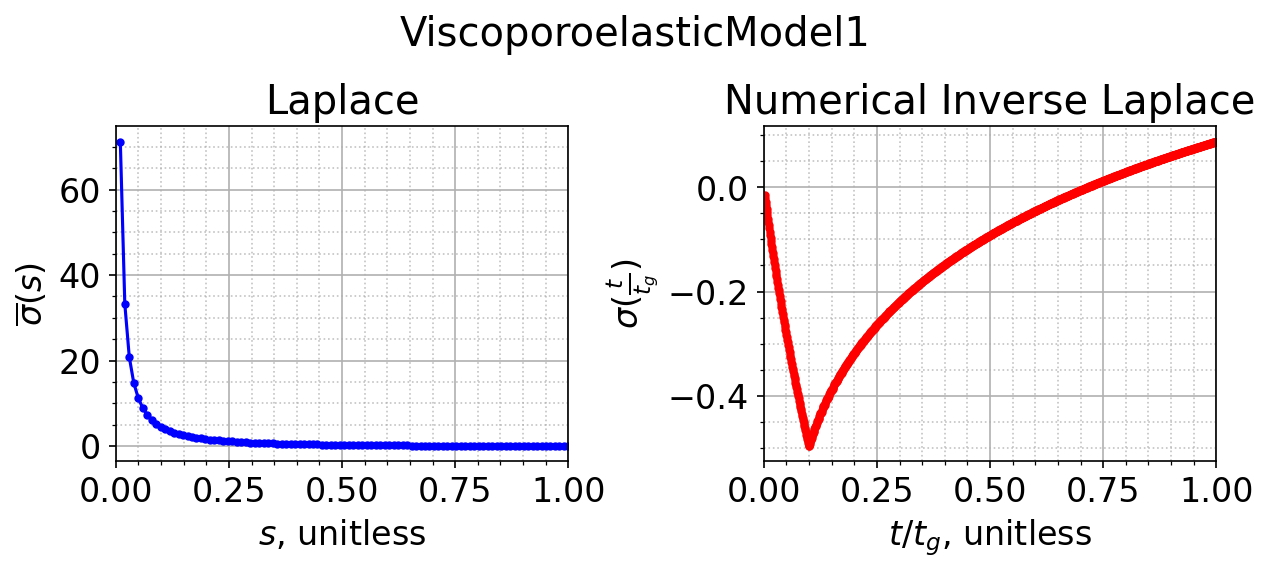

In [165]:
#@markdown Viscoporoelastic Model - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel1

warnings.simplefilter('error') # throws all warnings as errors
%pdb on

#@markdown Predefined constants
ViscoporoelasticModel1.t0_tg = 0.1 #@param {type:"number"} ; # 10 percent
ViscoporoelasticModel1.strain_rate = 0.01 #@param {type:"number"} ; # 1 percent per s (normally 1#/s)
## Below are directly determined by the mesh deformation part of the
## experiment (see our paper with Daniel).  -Dr. Spector
ViscoporoelasticModel1.Vrz = 0.24 #@param {type:"number"} ; # Not actually v, but greek nu (represents Poisson's ratio)
ViscoporoelasticModel1.Ezz =   19.19 #@param {type:"number"} ; # Note- don't mix up Ezz with epszz

vpe = ViscoporoelasticModel1()
#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
vpe.c =   1 #@param {type:"number"} ;
vpe.tau1 =  0.1 #@param {type:"number"} ;  # units = sec
vpe.tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
vpe.tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
vpe.Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
vpe.Err =  8.49 #@param {type:"number"};

tg = vpe.tg
t0_tg = vpe.t0_tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
func = vpe.laplace_value
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":"$t/t_g$, unitless", "s":"$s$, unitless"}
plot_s = np.linspace(0.01, 1, num=101, endpoint=True)
input_s = np.concatenate((plot_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, laplace_vals, inverted_vals_numerical, inverted_vals_analytical=plotting.plot_laplace_analysis(
    func=func, func_name=func_name, x_names=x_names, input_s=input_s, plot_s=plot_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, model_name = vpe.get_model_name())


df1 = pd.DataFrame({'Constant':vpe.get_predefined_constant_names(),'Value':vpe.get_predefined_constants()})
df2 = pd.DataFrame({'Fitted':vpe.get_fitted_parameter_names(),'Value':vpe.get_fitted_parameters()})
df3 = pd.DataFrame({'Value':vpe.get_predefined_constants()+vpe.get_fitted_parameters(),"Category":vpe.get_var_categories()}, index=vpe.get_predefined_constant_names()+vpe.get_fitted_parameter_names())
#display(df3)
display(pd.DataFrame(vpe.get_all_names_and_vars(),index=[vpe.get_model_name()]))

#output = r"\sigma(\frac{t}{tg})=0.7793021503277179 \text{ at } t/tg=150"
#display(IPython.display.Math(output))
itemindex = np.abs(input_times/tg - t0_tg).argmin()
display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
display(IPython.display.Math(fr"\text{{At }} s={s_vals[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*s_vals[0]:0.3f}"))



In [ ]:
dfs = []

plt.figure(figsize=(10, 5))
plt.rc('font', size=15)  # default font size is 10

#options = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
options = [0.65,0.7, 0.75]
colors = ["r"] + [""]*len(options)   #["r","",""]
#line_types = ["-","-","-","--","--","--",":"]
line_types = [".-"]*len(options)
for ind, Vrtheta in enumerate(options):
  vpe.Vrtheta = Vrtheta
  inverted_vals_numerical = euler_inversion(func, input_times/tg, Marg=None)
  laplace_vals = func(s_vals)
  #p=plt.plot(plot_times,inverted_vals_numerical, "rmg"[ind]+".-", linewidth=8,label=f"vs={vs}")
  p=plt.plot(s_vals,laplace_vals, colors[ind]+line_types[ind], linewidth=2, markersize=12, label=fr"$V_{{r\theta}}={Vrtheta}$")
  vars = vpe.get_all_names_and_vars()
  #vars={key:getattr(vpe,key) for key in dir(vpe) if not key.startswith("__") and not callable(getattr(vpe,key))}
  #dfs.append(pd.DataFrame(vars,index=["value"]))
  #dfs.append(pd.DataFrame(vars,index=[str(p[0].get_color())]))
  dfs.append(pd.DataFrame(vars,index=[f"Line #{ind+1} (Vrtheta={Vrtheta})"]))

plt.grid("major")
plt.grid(which="minor", alpha=0.75, linestyle=":")
ax = plt.gca()
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

plt.xlim([0, max(s_vals)])
#plt.ylim([0, None])
plt.ylim([0, 10])
plt.xlabel(x_names["s"])
#plt.xlim([0, None])
plt.ylabel(func_name["s"])
#plt.xlabel("t/tg, unitless")
plt.legend();
#plt.yticks(np.linspace(0,0.0005,5+1))
ax = plt.gca()
ax.yaxis.get_ticklocs(minor=True)
plt.legend(loc="upper right")
plt.title(vpe.get_model_name())

display(pd.concat(dfs))

In [ ]:
old_s_vals = s_vals
s_vals = np.arange(0.01, 30.01, 0.01)


dfs = []

plt.figure(figsize=(10, 5))
plt.rc('font', size=15)  # default font size is 10
plt.grid()

#options = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
options = [0.65, 0.75, 0.85]
colors = ["r"] + [""]*len(options)   #["r","",""]
line_types = [".-"]*len(options)
for ind, Vrtheta in enumerate(options):
  vpe.Vrtheta = Vrtheta
  inverted_vals_numerical = euler_inversion(func, input_times/tg, Marg=None)
  laplace_vals = func(s_vals)
  #p=plt.plot(plot_times,inverted_vals_numerical, "rmg"[ind]+".-", linewidth=8,label=f"vs={vs}")
  p=plt.plot(s_vals,s_vals*laplace_vals, colors[ind]+line_types[ind], linewidth=2, markersize=12, label=fr"$V_{{r\theta}}={Vrtheta}$")
  vars = vpe.get_all_names_and_vars()
  #vars={key:getattr(vpe,key) for key in dir(vpe) if not key.startswith("__") and not callable(getattr(vpe,key))}
  #dfs.append(pd.DataFrame(vars,index=["value"]))
  #dfs.append(pd.DataFrame(vars,index=[str(p[0].get_color())]))
  dfs.append(pd.DataFrame(vars,index=[f"Line #{ind+1} (Vrtheta={Vrtheta})"]))

plt.grid("major")
plt.grid(which="minor", alpha=0.75, linestyle=":")
ax = plt.gca()
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

plt.xlim([0, max(s_vals)])
#plt.ylim([-100, None])
plt.xlabel(x_names["s"])
#plt.xlim([0, None])
plt.ylabel(r"$s\cdot$"+func_name["s"])
#plt.xlabel("t/tg, unitless")
plt.legend();
#plt.yticks(np.linspace(0,0.0005,5+1))
ax = plt.gca()
ax.yaxis.get_ticklocs(minor=True)
plt.legend(loc="upper right")
plt.title(vpe.get_model_name())

display(pd.concat(dfs))

s_vals = old_s_vals

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

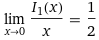

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
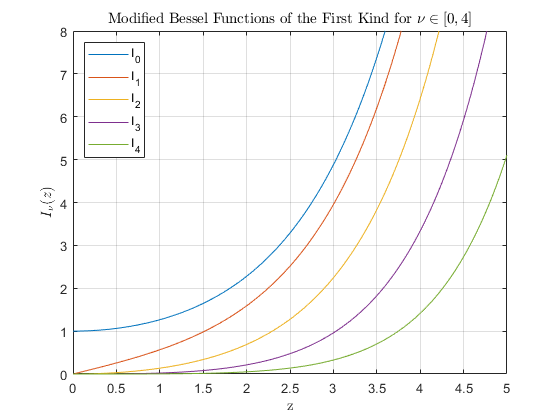

Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf
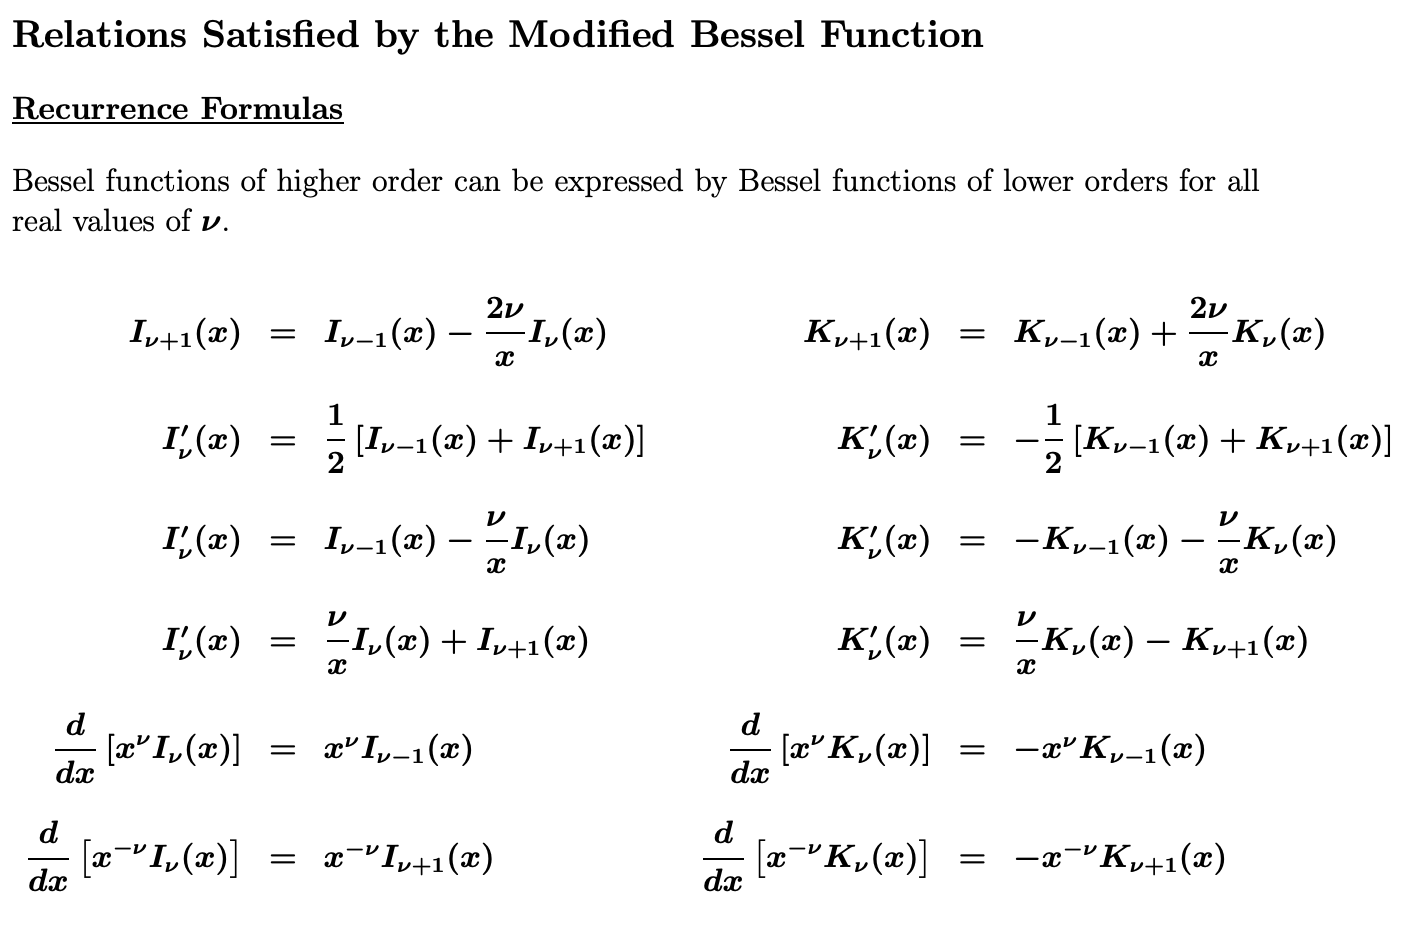